In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from BayDS.lib.io import *
from BayDS.lib.training import *
from BayDS.lib.selection import *

In [30]:
initial_data = pd.read_pickle('./FE/initial_data.pkl')
pos_idx = initial_data[initial_data['goal1']==1].index
neg_idx = initial_data[initial_data['goal1']==0].index


In [33]:
initial_data['field22'] = pd.Categorical(initial_data['field22'])
initial_data['field25'] = pd.Categorical(initial_data['field25'])

In [37]:
ddt = initial_data [initial_data['userid']=='a4837464e50075c4f8b5820dab011496ba1f04a985ab2782f5cafe6dda94ed52']# [['field0','field4','field16','goal1']].sort_values('field4').iloc[:20]

In [94]:
def shift(df,name='next', feature='field0', val=-1):
    shift_agg = lambda x: x.sort_index().shift(val)
    ddt_index=df.loc[:,['userid','field4',feature]].reset_index().set_index(['userid','field4']).sort_index()
    ddt_index.loc[:,name] = ddt_index[feature].agg(shift_agg)
    return ddt_index.set_index('orderid')[name]
    

### Days to next order

In [95]:
initial_data['daysToNextOrder'] = shift(initial_data)

In [96]:
initial_data[initial_data['daysToNextOrder'].isna()]

,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,...,bigkids_dividedBy_adults,pupes_dividedBy_adults,allkids_dividedBy_adults,is1Ticket,hasChildren,hasChildren_cumsum,price1_dividedBy_price2,price1_dividedBy_price2_field15,field17_times_field13,daysToNextOrder
orderid,,,,,,,,,,,,,,,,,,,,,
1081409,ffffec088571b537c70f463641966df601eaf356a40ad2...,0,-0.471365392208099,8,8,1,1,0,1,1,...,0.0,0.0,0.0,1,0,52826,1.25,1.25,2,NaN


In [97]:
train = initial_data[initial_data['goal1']>=0]
individual_gini('daysToNextOrder',train,train.goal1,-1)

5.7

In [98]:
initial_data['daysToNextOrder_dividedBy_field16'] = initial_data['daysToNextOrder'] /initial_data['field16'] 
train = initial_data[initial_data['goal1']>=0]
individual_gini('daysToNextOrder_dividedBy_field16',train,train.goal1,-1)

17.0

### Days to next flight

In [99]:
initial_data['daysToNextFlight'] = shift(initial_data) + shift(initial_data, feature='field16') 

In [100]:
train = initial_data[initial_data['goal1']>=0]
individual_gini('daysToNextFlight',train,train.goal1,-1)

0.2

In [101]:
initial_data['daysToNextFlight_dividedBy_field16'] = initial_data['daysToNextFlight'] /initial_data['field16'] 
train = initial_data[initial_data['goal1']>=0]
individual_gini('daysToNextFlight_dividedBy_field16',train,train.goal1,-1)

18.3

In [ ]:
#date of next flight - date of this flight

In [ ]:
#date of this flight - date of prev flight

### Category is changed

In [65]:
def add_cat_changed(df,name='next', feature=''):
    changed_agg = lambda x: np.clip(np.abs(x.astype(np.float32)-x.astype(np.float32).shift(1)).fillna(0),0,1).astype(np.uint8)
    ddt_index=df.loc[:,['userid','field4',cat]].reset_index().set_index(['userid','field4']).sort_index()
    ddt_index.loc[:,name] = ddt_index[feature].agg(changed_agg)
    return ddt_index.set_index('orderid')[name]

In [67]:
for cat in initial_data.columns:
    if initial_data[cat].dtype.name == 'category' and cat!='userid':
        initial_data[cat+'_changed'] = add_cat_changed(initial_data, feature=cat) 
        train = initial_data[initial_data['goal1']>=0]
        print (cat, individual_gini(cat+'_changed',train,train.goal1,-1))

field12 3.5000000000000004
field22 3.1
field25 10.2
field26 3.5000000000000004
field27 2.1
field29 1.0
field0bin 4.6
field6bin 6.0
field13bin 0.8999999999999999
field16bin 1.6
field17bin 4.8
field22bin 1.7000000000000002
field25bin 9.0
price1bin 0.4
price2bin 1.5


### Kids/Adults

In [70]:
initial_data['bigkids_dividedBy_adults'] = initial_data['field28'] /  initial_data['field24']
initial_data['pupes_dividedBy_adults'] = initial_data['field9'] /  initial_data['field24']
initial_data['allkids_dividedBy_adults'] = (initial_data['field9'] +initial_data['field28'] )/  initial_data['field24']
initial_data['is1Ticket'] = (2 - np.clip(initial_data['field15'],1,2))
initial_data['hasChildren'] = np.clip((initial_data['field9'] +initial_data['field28']), 0, 1)

train = initial_data[initial_data['goal1']>=0]
for col in ('bigkids_dividedBy_adults', 'pupes_dividedBy_adults', 'allkids_dividedBy_adults','is1Ticket'):
    scores = []
    for goal in ['goal1', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']:
        x = individual_gini(col,train,train[goal],-1)
        scores.append(x)
    print (col, scores)


bigkids_dividedBy_adults [0.8, 0.8999999999999999, 5.0, 4.0, 0.5, 9.2]
pupes_dividedBy_adults [0.3, 0.7000000000000001, 0.8999999999999999, 0.8999999999999999, 0.0, 2.3]
allkids_dividedBy_adults [0.5, 1.6, 5.3, 4.5, 0.1, 7.6]


In [90]:
def add_cumsum(df, feature=''):
    cumsum_agg = lambda x: x.cumsum()
    ddt_index=df.loc[:,['userid','field4',feature]].reset_index().set_index(['userid','field4']).sort_index()
    ddt_index.loc[:,'cumsum'] = ddt_index[feature].agg(cumsum_agg)
    return ddt_index.set_index('orderid')['cumsum']

initial_data['hasChildren_cumsum'] = add_cumsum(initial_data,feature='hasChildren')

train = initial_data[initial_data['goal1']>=0]
for col in ('hasChildren_cumsum',):
    scores = []
    for goal in ['goal1', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']:
        x = individual_gini(col,train,train[goal],-1)
        scores.append(x)
    print (col, scores)

hasChildren_cumsum [1.4000000000000001, 4.7, 2.8000000000000003, 4.7, 2.8000000000000003, 3.0]


In [93]:
initial_data['price1_dividedBy_price2'] = initial_data['price1'] /  initial_data['price2']
initial_data['price1_dividedBy_price2_field15'] = initial_data['price1'] /  initial_data['price2'] / initial_data['field15']
initial_data['field17_times_field13'] = initial_data['field17'] * initial_data['field13'] 
train = initial_data[initial_data['goal1']>=0]
for col in ('price1_dividedBy_price2','price1_dividedBy_price2_field15','field17_times_field13'):
    scores = []
    for goal in ['goal1', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']:
        x = individual_gini(col,train,train[goal],-1)
        scores.append(x)
    print (col, scores)

price1_dividedBy_price2 [9.5, 21.5, 22.1, 15.8, 12.2, 37.5]
price1_dividedBy_price2_field15 [10.9, 20.0, 15.1, 16.3, 12.6, 35.5]
field17_times_field13 [9.700000000000001, 8.7, 5.8999999999999995, 13.4, 6.800000000000001, 21.2]


In [103]:
initial_data.columns

Index(['userid', 'field0', 'field1', 'field2', 'field3', 'field4', 'field5',
       'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field12',
       'field13', 'field14', 'field15', 'field16', 'field17', 'field18',
       'field19', 'field20', 'field21', 'field22', 'field23', 'field24',
       'field25', 'field26', 'field27', 'field28', 'field29',
       'indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1', 'price1', 'price2', 'field0bin',
       'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin',
       'field25bin', 'price1bin', 'price2bin', 'field12_changed',
       'field22_changed', 'field25_changed', 'field26_changed',
       'field27_changed', 'field29_changed', 'field0bin_changed',
       'field6bin_changed', 'field13bin_changed', 'field16bin_changed',
       'field17bin_changed', 'field22bin_changed', 'field25bin_changed',
     

In [104]:
initial_data.to_parquet('./FE_MANUAL/fe.pqt')

In [81]:
col = 'hasChildren'
ddt = initial_data [initial_data['userid']=='a4837464e50075c4f8b5820dab011496ba1f04a985ab2782f5cafe6dda94ed52']# [['field0','field4','field16','goal1']].sort_values('field4').iloc[:20]
ddt_index=ddt.loc[:,['userid','field4',col]].reset_index().set_index(['userid','field4']).sort_index()

In [83]:
ddt_index['hasChildren'].sum()

6

In [86]:
ddt_index['hasChildren'].agg(lambda x: x.cumsum())

userid                                                            field4
a4837464e50075c4f8b5820dab011496ba1f04a985ab2782f5cafe6dda94ed52  1         0
                                                                  2         0
                                                                  3         0
                                                                  4         0
                                                                  5         0
                                                                           ..
                                                                  359       6
                                                                  360       6
                                                                  361       6
                                                                  362       6
                                                                  363       6
Name: hasChildren, Length: 363, dtype: int32

In [109]:
initial_data [initial_data['userid']=='a4837464e50075c4f8b5820dab011496ba1f04a985ab2782f5cafe6dda94ed52'] [['field0','field4','daysToNextOrder','field16','goal1']].sort_values('field4').iloc[:20]

,field0,field4,daysToNextOrder,field16,goal1
orderid,,,,,
1162877,0,1,0.0,1,0
1125446,0,2,0.0,1,0
1039421,0,3,16.0,1,0
1174386,16,4,0.0,4,0
1083155,0,5,1.0,5,1
1186621,1,6,0.0,5,0
1102930,0,7,3.0,8,0
1189031,3,8,0.0,3,0
1177676,0,9,0.0,4,0


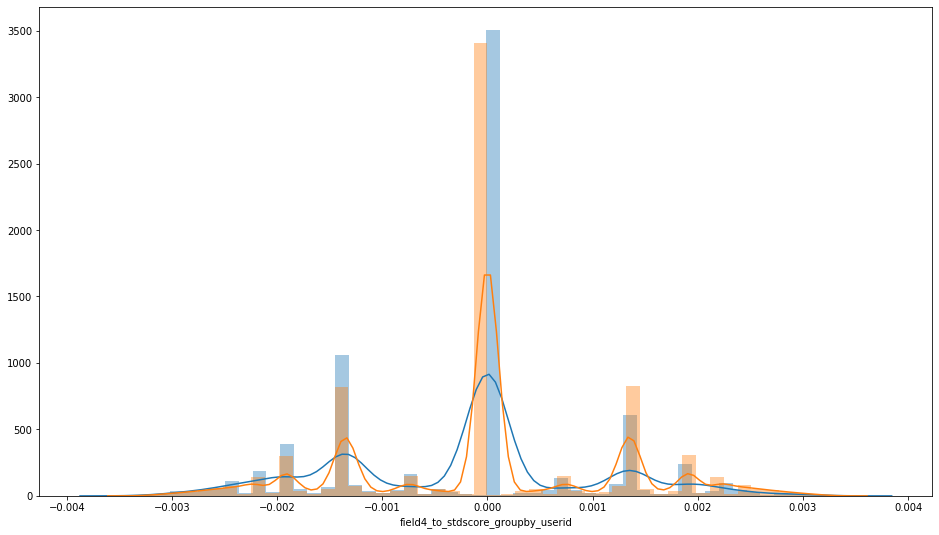

In [37]:
f = data['field4_to_stdscore_groupby_userid'].compute()
df = pd.DataFrame(index=initial_data[initial_data.goal1>=0].index)
df['goal'] = initial_data.goal1
df['feature'] = f
plt.figure(figsize=(16,9))
# sns.scatterplot(x='feature', y='goal', data=df)
sns.distplot(f.loc[pos_idx],bins=50)
sns.distplot(f.loc[neg_idx],bins=50)
# plt.yscale('log')

In [ ]:
f = data['field4_to_stdscore_groupby_userid'].compute()
df = pd.DataFrame(index=initial_data[initial_data.goal1>=0].index)
df['goal'] = initial_data.goal1
df['feature'] = f
plt.figure(figsize=(16,9))
# sns.scatterplot(x='feature', y='goal', data=df)
sns.distplot(f.loc[pos_idx],bins=50)
sns.distplot(f.loc[neg_idx],bins=50)
# plt.yscale('log')